##### Copyright 2023 Melchor Lafuente Duque

# AUDIO TO IMAGE - DCT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os

# Functions to read and write wav, txt and npy files

In [3]:
def read_wav(file_name, dir_name_input = "OUTPUT_1"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

In [4]:
def write_txt(output_dir_name, signal_name, filename, data, data_type = '%d'):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".txt")
    np.savetxt(filename_output, [data], fmt = data_type)

In [5]:
def write_npy(output_dir_name, signal_name, filename, data):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".npy")
    np.save(filename_output, data)

# AUDIO TO IMAGE

## AUDIO TO Freq ARRAY - using DCT

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I just use the first one (the number zero):

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #0,1,2,3

We read the .wav files we are going to work with:

In [7]:
# Step 1: Read the WAV file into memory
file_name_origin = "ORIGINAL_PROCESED"
sample_rate_origin, original_signal = read_wav(file_name_origin)

file_name_style = "STYLE_PROCESED"
sample_rate_style, style_signal = read_wav(file_name_style)

We define a function to plot the signals and we do so:

In [11]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

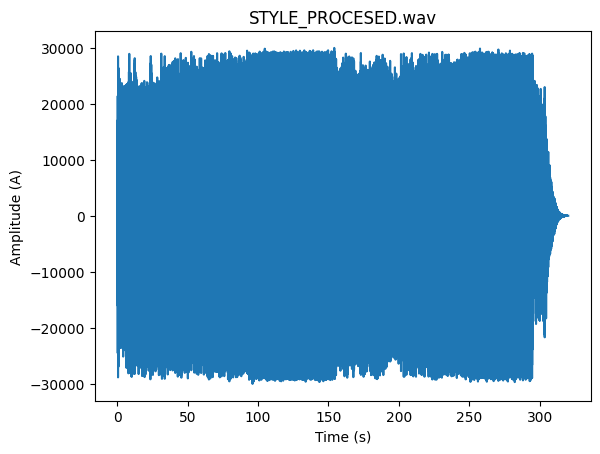

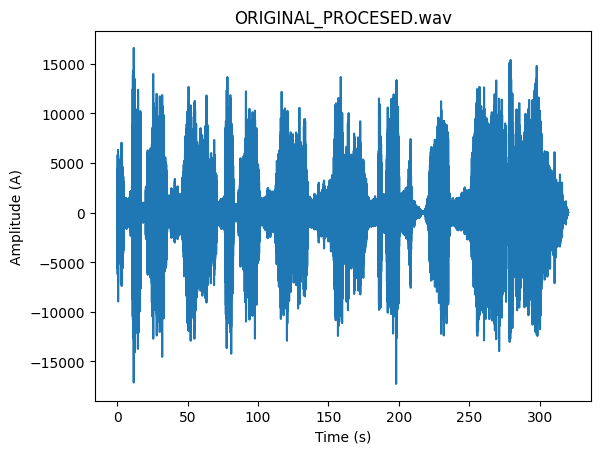

In [12]:
plot_signal(sample_rate_style, style_signal, file_name_style)
plot_signal(sample_rate_origin, original_signal, file_name_origin)

We define a function to apply the dct to the audio files. In this function, we also will save the following elements:

* the signs matrix 
* the sample rate of the audio
* the number of samples that we obtain
* the length of the window that goes through the audio file applying the dct

In [13]:
def obtain_signs(mat):
    return np.where(mat >= 0, 1, -1)

In [14]:
def obtain_freq_array(signal, sample_rate = 48000, sample_anchor = 0.02, output_dir_name = "OUTPUT_2", signal_name = "ORIGINAL", mat_signs_filename = "mat_signs", sample_rate_filename = "sample_rate", n_samples_filename = "n_samples", segment_length_filename = "segment_length"):

    # Pre-process the signal by normalizing it to [-1, 1] range
    signal = signal / (2.0 ** 15)

    # Define the segment length for the DCT
    segment_length = round(sample_anchor * sample_rate) # sample_anchor: 20 ms
    
    # Save the sample_rate
    write_txt(output_dir_name, signal_name, sample_rate_filename, sample_rate)
    
    # Save the n_samples
    write_txt(output_dir_name, signal_name, n_samples_filename, len(signal))
    
    # Save the segment_length
    write_txt(output_dir_name, signal_name, segment_length_filename, segment_length)
    
    # Calculate the number of segments needed to cover the entire signal
    num_segments = len(signal) // segment_length

    # Apply DCT to each segment of the signal using a sliding window approach
    dct_segments = np.array([sp.dct(signal[i:i+segment_length], type=2) for i in range(0, len(signal)-segment_length, segment_length)])

    # Obtain the signs of the matrix
    mat_signs = obtain_signs(dct_segments)
    
    # Save the NumPy array to a file
    write_npy(output_dir_name, signal_name, mat_signs_filename, mat_signs)

    # Convert the DCT coefficients to a 2D frequency domain image
    freq_array = np.abs(dct_segments)
    
    # Apply logarithmic scaling to the magnitude values for visualization purposes
    freq_array = np.log(freq_array + 1)
    
    return freq_array, mat_signs, segment_length

In [15]:
def plot_freq_array(freq_array):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    fig.show()

The image below has a dimension of:  (662, 21341)
The image below has a dimension of:  (662, 21341)


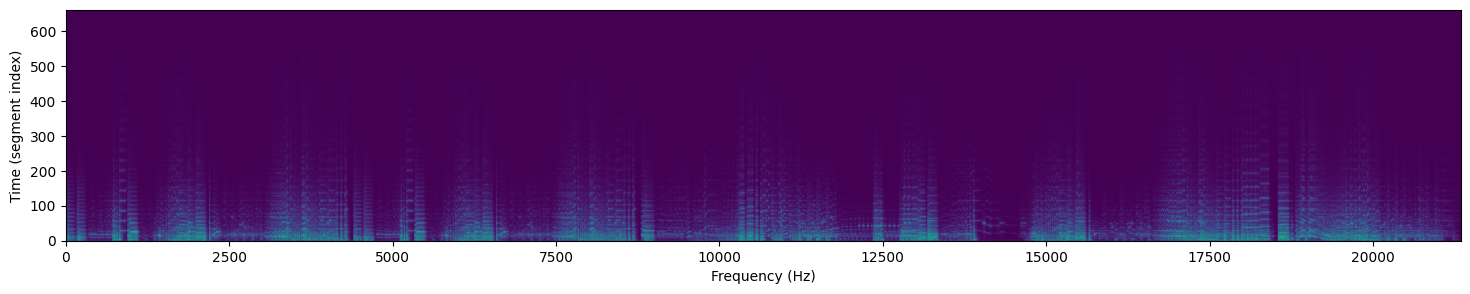

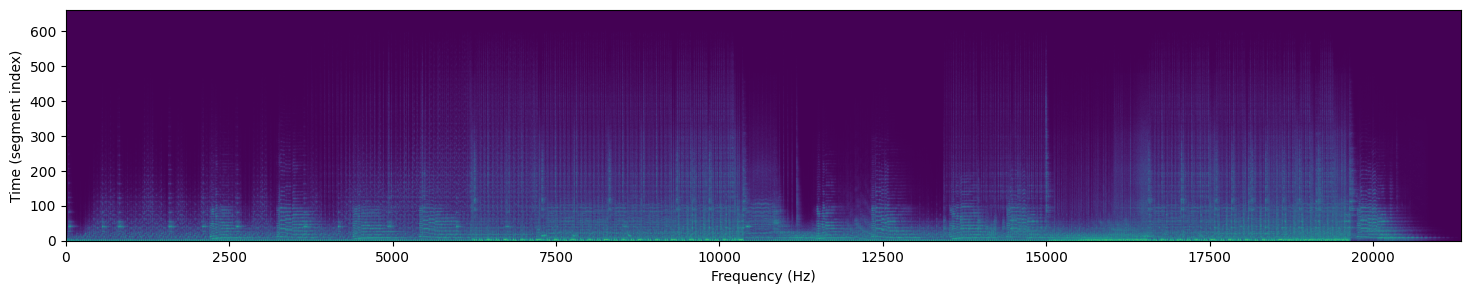

In [17]:
signal = original_signal.copy()
freq_array_origin, mat_signs_origin, segment_length_origin = obtain_freq_array(signal, sample_rate_origin, sample_anchor = 0.015, output_dir_name = "OUTPUT_2/ORIGIN", signal_name = "ORIGINAL")
plot_freq_array(freq_array_origin)

signal = style_signal.copy()
freq_array_style, mat_signs_style, segment_length_style = obtain_freq_array(signal, sample_rate_style, sample_anchor = 0.015, output_dir_name = "OUTPUT_2/STYLE", signal_name = "STYLE")
plot_freq_array(freq_array_style)

## Save freq array as image

Let's conclude the whole process to transform audio signals to image:

In [19]:
def save_max_min(freq_image, output_dir_name = "OUTPUT_2", signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):    
    write_txt(output_dir_name, signal_name, max_filename, freq_image.max(), data_type='%1.18f')
    write_txt(output_dir_name, signal_name, min_filename, freq_image.min(), data_type='%1.18f')

In the following function, they will give us a frequency domain array normalized between the values 0 and 1 and we'll transform it into a grey image within the values 0 and 255:

In [20]:
def save_array_as_image(arr_normalized, output_dir_name = "OUTPUT_2", signal_name = "ORIGINAL", img_filename = "image", img_suffix = "png"):#, frac_filename = "floating_part", frac_suffix = "npy"):
    
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    
    # normalize the values of the frequency domain array between 0 and 255
    frac_part, int_part = np.modf(arr_normalized * 255)
    img = Image.fromarray(int_part.astype(np.uint8))
    
    # save the image
    img_filename = signal_name + "_" + img_filename + "." + img_suffix
    filename_output = os.path.join(output_path, img_filename)

    img.save(filename_output)

In [21]:
# ORIGIN
# We save the max and min values from the frequency array
save_max_min(freq_array_origin, signal_name = "ORIGINAL", output_dir_name = "OUTPUT_2/ORIGIN")

# normalize the array to the range [0,1]
arr_normalized_origin = (freq_array_origin.T - freq_array_origin.T.min()) / (freq_array_origin.T.max() - freq_array_origin.T.min())
save_array_as_image(arr_normalized_origin, signal_name = "ORIGINAL", output_dir_name = "OUTPUT_2/ORIGIN")

# STYLE
# We save the max and min values from the frequency array
save_max_min(freq_array_style, signal_name = "STYLE", output_dir_name = "OUTPUT_2/STYLE")

# normalize the array to the range [0,1]
arr_normalized_style = (freq_array_style.T - freq_array_style.T.min()) / (freq_array_style.T.max() - freq_array_style.T.min())
save_array_as_image(arr_normalized_style, signal_name = "STYLE", output_dir_name = "OUTPUT_2/STYLE")